# 🗺️ ZH Classification Notebook

Clasificación binaria de predios según la variable `debe_actualizarse`.

- **1** = el predio intersecta 2 o más zonas homogéneas → requiere actualización.
- **0** = el predio intersecta solo una zona homogénea → está OK.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

## 📥 Cargar dataset de predios

In [2]:
df = pd.read_csv('../Datasets/processed/predios_multizh_FULL.csv')
df.head()

,UID_PREDIO,area_predio,perim_predio,compactness,PRM_PROVIN,PRM_CANTON,PRM_DISTRI,USO,n_zh_unicas,debe_actualizarse
0,2010100001820M,1453.438929,297.853900,0.205873,2.0,1.0,1.0,0,2,1
1,20101000022800,403.580921,89.008279,0.640147,2.0,1.0,1.0,0,1,0
2,2010100002480M,1293.693771,176.763001,0.520306,2.0,1.0,1.0,0,1,0
3,2010100002860M,755.305891,112.402487,0.751244,2.0,1.0,1.0,0,3,1
4,2010100003180M,432.587673,86.409932,0.728042,2.0,1.0,1.0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82360 entries, 0 to 82359
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID_PREDIO         82360 non-null  object 
 1   area_predio        82360 non-null  float64
 2   perim_predio       82360 non-null  float64
 3   compactness        82360 non-null  float64
 4   PRM_PROVIN         82359 non-null  float64
 5   PRM_CANTON         82359 non-null  float64
 6   PRM_DISTRI         82359 non-null  float64
 7   USO                82360 non-null  int64  
 8   n_zh_unicas        82360 non-null  int64  
 9   debe_actualizarse  82360 non-null  int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 6.3+ MB


## 🎯 Distribución de la variable objetivo `debe_actualizarse`

In [4]:
df['debe_actualizarse'].value_counts(), df['debe_actualizarse'].value_counts(normalize=True).round(3)

(debe_actualizarse
 0    67706
 1    14654
 Name: count, dtype: int64,
 debe_actualizarse
 0    0.822
 1    0.178
 Name: proportion, dtype: float64)

## 🧩 Definir features (X) y target (y)

Usaremos:
- **Numéricas**: `area_predio`, `perim_predio`, `compactness`
- **Categóricas**: `PRM_PROVIN`, `PRM_CANTON`, `PRM_DISTRI`, `USO` (las que existan)

In [5]:
target_col = 'debe_actualizarse'

numeric_features = ['area_predio', 'perim_predio', 'compactness']
candidate_cat = ['PRM_PROVIN', 'PRM_CANTON', 'PRM_DISTRI', 'USO']
categorical_features = [c for c in candidate_cat if c in df.columns]

print('Features numéricas:', numeric_features)
print('Features categóricas:', categorical_features)

X = df[numeric_features + categorical_features].copy()
y = df[target_col].astype(int)

Features numéricas: ['area_predio', 'perim_predio', 'compactness']
Features categóricas: ['PRM_PROVIN', 'PRM_CANTON', 'PRM_DISTRI', 'USO']


## 🧪 Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((65888, 7), (16472, 7))

## ⚙️ Preprocesamiento (escalado + one-hot encoding)

Usamos un `ColumnTransformer` para:
- Escalar variables numéricas (`StandardScaler`)
- One-hot encoding para variables categóricas (`OneHotEncoder`)

In [7]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 🤖 Definición de modelos

Modelos a comparar:
1. Regresión Logística
2. Árbol de Decisión
3. kNN
4. MLP (Red Neuronal)

In [8]:
models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1
    ),
    'DecisionTree': DecisionTreeClassifier(
        max_depth=8,
        min_samples_split=50,
        class_weight='balanced',
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=15
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(32, 16),
        max_iter=300,
        random_state=42
    )
}

## 📊 Entrenamiento y evaluación de modelos

In [9]:
results = []
probas = {}

for name, clf in models.items():
    print(f"\nEntrenando modelo: {name}")

    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('clf', clf)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append({
        'modelo': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': auc
    })

    if y_proba is not None:
        probas[name] = y_proba

results_df = pd.DataFrame(results)
results_df.sort_values(by='f1', ascending=False)


Entrenando modelo: LogisticRegression

Entrenando modelo: DecisionTree

Entrenando modelo: KNN

Entrenando modelo: MLP


,modelo,accuracy,precision,recall,f1,roc_auc
1,DecisionTree,0.671807,0.291772,0.591607,0.390805,0.704505
0,LogisticRegression,0.682067,0.282699,0.511771,0.364210,0.666096
2,KNN,0.827465,0.557568,0.147049,0.232721,0.696374
3,MLP,0.830925,0.690104,0.090413,0.159879,0.710341


## 📈 Curvas ROC de los modelos (si hay probabilidades disponibles)

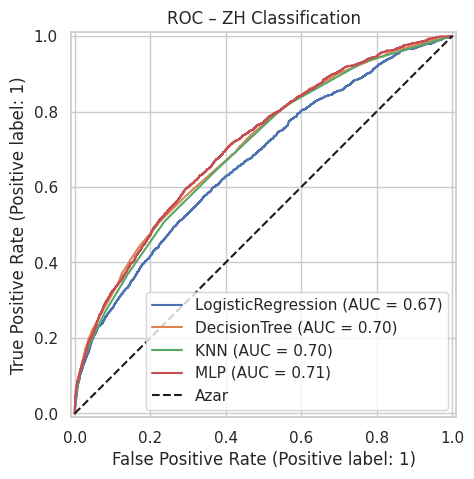

In [10]:
if probas:
    plt.figure(figsize=(7,5))
    for name, y_proba in probas.items():
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=plt.gca())

    plt.plot([0,1],[0,1],'k--', label='Azar')
    plt.title('ROC – ZH Classification')
    plt.legend()
    plt.show()
else:
    print('Ningún modelo expone predict_proba, no se pueden graficar ROC.')

## 🧮 Matriz de confusión del mejor modelo (según F1)

Mejor modelo según F1: DecisionTree


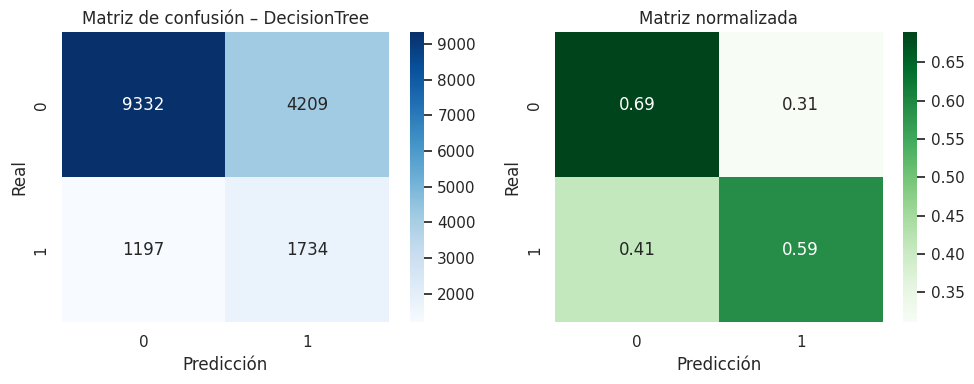

In [11]:
best_model_name = results_df.sort_values(by='f1', ascending=False).iloc[0]['modelo']
print('Mejor modelo según F1:', best_model_name)

best_clf = models[best_model_name]

best_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', best_clf)
])

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f'Matriz de confusión – {best_model_name}')
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Real')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax[1])
ax[1].set_title('Matriz normalizada')
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Real')

plt.tight_layout()
plt.show()